In [16]:
import os
import sys
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import traci
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns


## **SUMO Config**

In [ ]:
def sumo_config(traffic_pattern="P1"):
    sumo_config = [
        "sumo-gui",
        "-c", f"SUMO_networks/{traffic_pattern}/junction.sumocfg",
        "--step-length", "0.05",
        "--delay", "0",
        "--lateral-resolution", "0.1",
        "--waiting-time-memory", "500",
        "--start",
        "--no-warnings",
        "--no-step-log",
    ]
    return sumo_config

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Declare SUMO_HOME env variable")

if not traci.isLoaded():
    traci.start(sumo_config())


def reset_env(pattern="P1"):
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern))


## **Plot helper function**

In [3]:
sns.set(style="whitegrid", context="notebook", palette="deep")

def plot_line(rewards, label, ylabel, title, baselines=None):
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette("deep")
    main_color = palette[0]

    plt.plot(rewards, label=label, linewidth=2.5, marker='o', markersize=4,
             alpha=0.9, color=main_color)

    if baselines is not None:
        labels = ["P1: Major/minor road", "P2: Through/left-turn lane ", "P3: Tidal traffic"]
        for i, val in enumerate(baselines):
            if val is not None:
                color = palette[i + 1] if i + 1 < len(palette) else 'gray'
                label_text = labels[i] if i < len(labels) else f"P{i+1}"
                plt.axhline(y=val, color=color, linestyle='--', linewidth=2,
                            alpha=0.8, label=label_text)

    plt.xlabel("Episode", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, weight='bold')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


## **Simulation Setup**

In [4]:
# Global Variables for Simulation
action_space_size = 8
TRAFFIC_LIGHT_ID = "traffic_light"
DELTA_PHASE_DURATION = 6 
YELLOW_PHASE_DURATION = 4 
lane_detectors = [f'q{i+1}' for i in range(8)]
current_phase = 2


In [5]:
# Returns the queue length for each lane detector
def get_queue_length():
    return torch.tensor([
        traci.lanearea.getLastStepHaltingNumber(d) for d in lane_detectors
    ], dtype=torch.float)

# The current state is defined as queue length for each lane detector
def get_current_state():
    return get_queue_length()

# Simulate 20 seconds
def simulate_time(seconds=1):
    for _ in range(20 * seconds):
        traci.simulationStep()


In [6]:
def step(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
        
    next_state = get_current_state()
    reward = -torch.sum(next_state)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, next_state.clone() 


### Q-Network Architecture

In [7]:
traffic_patterns = itertools.cycle(["P1", "P2", "P3", "P4"])

def change_env():
    pattern = next(traffic_patterns)
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern))


In [8]:
def choose_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_space_size - 1)
    else:
        return torch.argmax(policy_net(state.unsqueeze(0))).item()


In [9]:
def optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states = torch.stack([x[0] for x in batch])
    actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
    rewards = torch.tensor([x[2] for x in batch], dtype=torch.float)
    next_states = torch.stack([x[3] for x in batch])
    dones = torch.tensor([x[4] for x in batch], dtype=torch.float)

    q_vals = policy_net(states).gather(1, actions).squeeze()
    with torch.no_grad():
        max_next_q_vals = target_net(next_states).max(1)[0]
        target_vals = rewards + gamma * max_next_q_vals * (1 - dones)
    loss = nn.MSELoss()(q_vals, target_vals)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## **Baseline Model: Mimicing TrafficLightsNSW**

In [9]:

def get_baseline_results(episodes=40):
    pattern_names = ["P1", "P2", "P3", "P4"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)
    pattern_queue_lengths = {p: [] for p in pattern_names}

    baseline_all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    phase_sequence = [2, 6, 4, 0]
    green_duration = DELTA_PHASE_DURATION
    yellow_duration = YELLOW_PHASE_DURATION

    for episode in range(episodes):
        print(f"[Baseline] Episode {episode}")
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        change_env()

        episode_reward = 0
        done = False
        num_steps = 0

        vehicle_wait_tracker = {}
        queue_length_tracker = {}

        state = get_current_state()
        phase_index = 0

        while not done:
            green_phase = phase_sequence[phase_index]
            yellow_phase = green_phase + 1

            # Green
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, green_phase)
            simulate_time(green_duration)
            num_steps += green_duration * 20

            # Reward
            state = get_current_state()
            queue_size = torch.sum(state)
            reward = -queue_size
            episode_reward += reward

            # Wait tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker or wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            curr_queue = get_queue_length()
            # print(curr_queue)
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            done = traci.simulation.getMinExpectedNumber() == 0
            if done:
                break

            # Yellow
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, yellow_phase)
            simulate_time(yellow_duration)
            num_steps += yellow_duration * 20

            done = traci.simulation.getMinExpectedNumber() == 0
            phase_index = (phase_index + 1) % len(phase_sequence)

        # print("Steps per episode:", num_steps)

        avg_queue_lengths = [queue_length_tracker.get(i, 0.0) / num_steps for i in range(len(lane_detectors))]
        pattern_queue_lengths[current_pattern].append(avg_queue_lengths)

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        pattern_rewards[current_pattern].append(episode_reward)
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

        # print(torch.sum(baseline_all_avg_queue_lengths[:, episode]))

    for pattern in pattern_names:
        print(f"\nPattern {pattern}:")
        print(f"  Episodes: {pattern_episode_count[pattern]}")
        print(f"  Avg Reward: {sum(pattern_rewards[pattern]) / len(pattern_rewards[pattern]):.2f}")
        print(f"  Avg Wait: {sum(pattern_avg_waits[pattern]) / len(pattern_avg_waits[pattern]):.2f}")
        print(f"  Max Wait: {max(pattern_max_waits[pattern]):.2f}")

    return (
        pattern_rewards,
        pattern_avg_waits,
        pattern_max_waits,
        pattern_queue_lengths
    )


In [10]:
baseline_results = get_baseline_results(episodes=40)
baseline_rewards, baseline_avg_waits, baseline_max_waits, baseline_queues = baseline_results


[Baseline] Episode 0
[Baseline] Episode 1
[Baseline] Episode 2
[Baseline] Episode 3
[Baseline] Episode 4
[Baseline] Episode 5
[Baseline] Episode 6
[Baseline] Episode 7
[Baseline] Episode 8
[Baseline] Episode 9
[Baseline] Episode 10
[Baseline] Episode 11
[Baseline] Episode 12
[Baseline] Episode 13
[Baseline] Episode 14
[Baseline] Episode 15
[Baseline] Episode 16
[Baseline] Episode 17
[Baseline] Episode 18
[Baseline] Episode 19
[Baseline] Episode 20
[Baseline] Episode 21
[Baseline] Episode 22
[Baseline] Episode 23
[Baseline] Episode 24
[Baseline] Episode 25
[Baseline] Episode 26
[Baseline] Episode 27
[Baseline] Episode 28
[Baseline] Episode 29
[Baseline] Episode 30
[Baseline] Episode 31
[Baseline] Episode 32
[Baseline] Episode 33
[Baseline] Episode 34
[Baseline] Episode 35
[Baseline] Episode 36
[Baseline] Episode 37
[Baseline] Episode 38
[Baseline] Episode 39

Pattern P1:
  Episodes: 10
  Avg Reward: -2758.00
  Avg Wait: 14.57
  Max Wait: 31.25

Pattern P2:
  Episodes: 10
  Avg Reward: -

## **Architecture 1: Fully Connected Q-Network**

In [10]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.main(x)


In [11]:
# The current state is defined as queue length for each lane detector
def get_current_state():
    return get_queue_length()


In [ ]:
# Add per-lane metrics
def train_algorithm(params, episodes=200):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    state_dim = len(lane_detectors)
    policy_net = DQN(state_dim, action_space_size)
    target_net = DQN(state_dim, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    steps_done = 0

    pattern_names = ["P1", "P2", "P3"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)

    for episode in range(episodes):
        change_env()
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        state = get_current_state()
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        # Aggregate queue stats
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards[current_pattern].append(episode_reward.item())
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

    N = max(1, int(0.2 * episodes))  # 20% of episodes
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [69]:
optimal_params = {
    "gamma": 0.99,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}


In [ ]:
fc_results = train_algorithm(optimal_params, episodes=200)


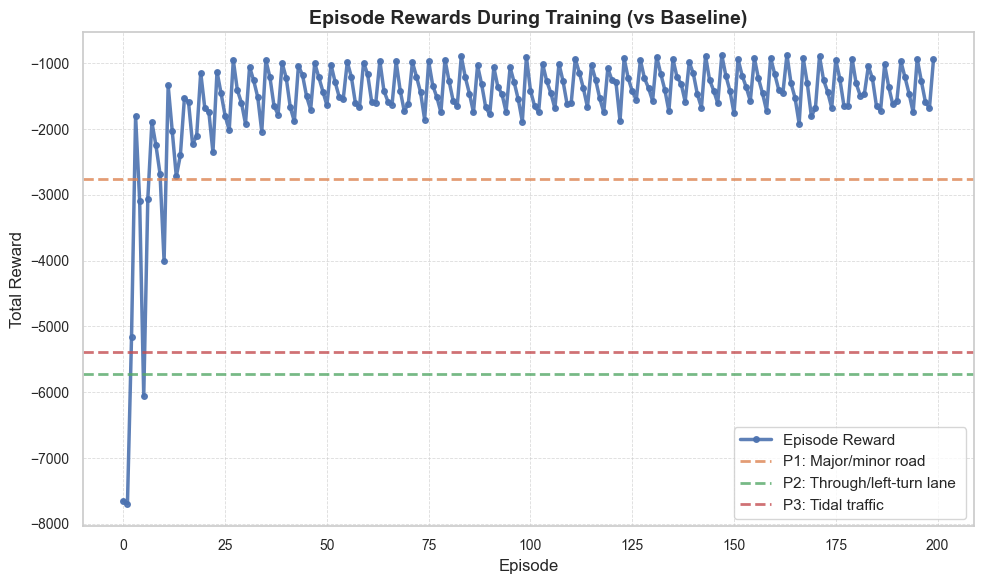

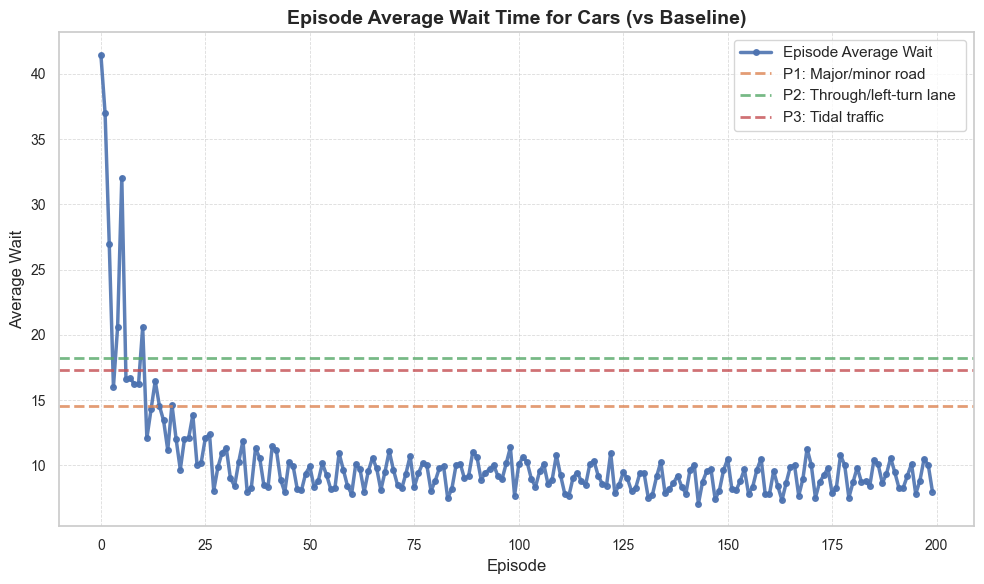

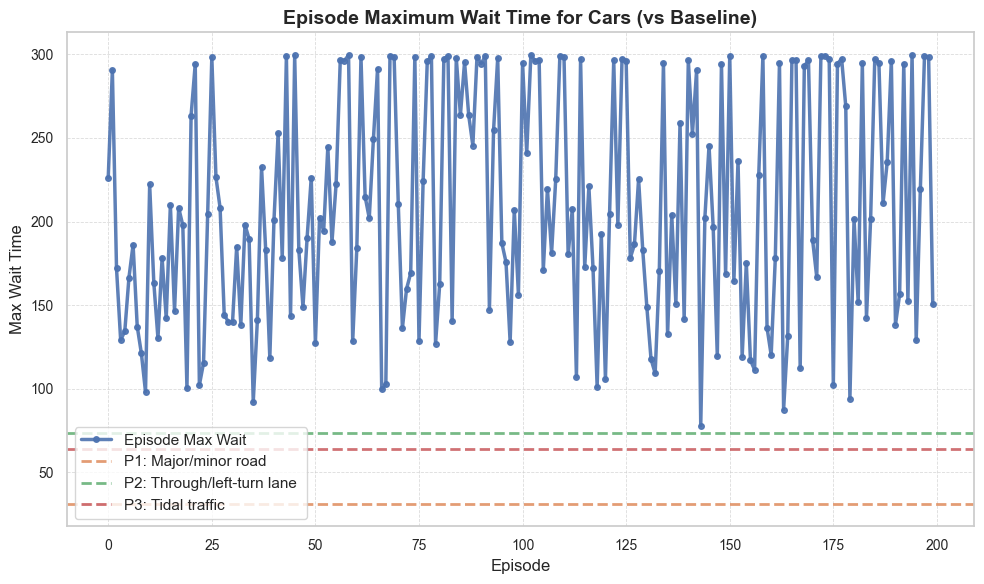

In [128]:
plot_line(fc_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2758, -5730, -5383])
plot_line(fc_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [14.57, 18.23, 17.33])
plot_line(fc_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [31.25, 73.55, 64.05])


In [82]:
print("### Fully Connected Q-Network Results ###")
for pattern in ["P1", "P2", "P3"]:
    rewards = fc_results["pattern_rewards"][pattern]
    avg_waits = fc_results["pattern_avg_waits"][pattern]
    max_waits = fc_results["pattern_max_waits"][pattern]
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


### Fully Connected Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1528.90
 Avg Wait: 10.16
 Max Wait: 299.70

Pattern P2:
 Episodes: 67
 Avg Reward: -1633.58
 Avg Wait: 10.70
 Max Wait: 299.40

Pattern P3:
 Episodes: 66
 Avg Reward: -1549.50
 Avg Wait: 10.26
 Max Wait: 299.70


In [37]:
policy_fc = fc_results["trained_model"]
model_path = f"policy_fc_nn.pt"
torch.save(policy_fc.state_dict(), model_path)


In [12]:
def evaluate_fc_model_on_pattern(pattern, model_path=f"policy_fc_nn.pt", episodes=1):
    policy_net = DQN(len(lane_detectors), action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state()

        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
                
            next_state, reward, done, curr_queue = step(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [13]:
for pattern in ["P1", "P2", "P3", "P4"]:
    fc_results = evaluate_fc_model_on_pattern(pattern, episodes=1)
    rewards = fc_results["pattern_rewards"]
    avg_waits = fc_results["pattern_avg_waits"]
    max_waits = fc_results["pattern_max_waits"]

    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


C:\Users\alexw\AppData\Local\Temp\ipykernel_20204\2286365116.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path))
C:\Users\


Pattern P1:
 Episodes: 1
 Avg Reward: -1198.00
 Avg Wait: 11.09
 Max Wait: 300.05

Pattern P2:
 Episodes: 1
 Avg Reward: -1420.00
 Avg Wait: 13.42
 Max Wait: 182.60

Pattern P3:
 Episodes: 1
 Avg Reward: -1677.00
 Avg Wait: 13.88
 Max Wait: 497.00

Pattern P4:
 Episodes: 1
 Avg Reward: -963.00
 Avg Wait: 10.97
 Max Wait: 300.05


## **Architecture 2: CNN Q-Network**

In [10]:
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv3(x))   
        
        x = x.view(x.size(0), -1)   
        x = F.relu(self.fc1(x))
        return self.output(x)      


In [11]:
def generate_occupancy_grid(grid_size=(84, 84),
                             bounds=(-115, 100, -90, 125)):
    x_min, x_max, y_min, y_max = bounds
    x_scale = grid_size[1] / (x_max - x_min)
    y_scale = grid_size[0] / (y_max - y_min)

    grid = torch.zeros(grid_size, dtype=torch.float32)

    for v_id in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(v_id)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = int((x - x_min) * x_scale)
            row = int((y - y_min) * y_scale)

            if 0 <= row < grid_size[0] and 0 <= col < grid_size[1]:
                grid[row, col] = 1.0  

    return grid

frame_buffer = deque(maxlen=4)

def get_current_state():
    frame_buffer.clear()  # clear previous frames to maintain consistency

    for _ in range(4):
        simulate_time(1)  # simulate 1 second
        grid = generate_occupancy_grid()
        frame_buffer.append(grid.unsqueeze(0))

    state = torch.cat(list(frame_buffer), dim=0)
    return state


def step(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    next_state = get_current_state()
    queue_length = get_queue_length()
    reward = -torch.sum(queue_length)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, queue_length


In [85]:
# Add per-lane metrics
def train_algorithm(params, episodes=200):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    policy_net = DQN(action_space_size)
    target_net = DQN(action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    steps_done = 0

    pattern_names = ["P1", "P2", "P3"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)

    for episode in range(episodes):
        change_env()
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        state = get_current_state()
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards[current_pattern].append(episode_reward.item())
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

        print(f"[CNN] Episode {episode}: Reward {episode_reward.item():.2f}")

    N = max(1, int(0.2 * episodes))
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [86]:
optimal_params = {
    "gamma": 0.999,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}


In [ ]:
cnn_results = train_algorithm(optimal_params, episodes=200)


[CNN] Episode 0: Reward -4539.00
[CNN] Episode 1: Reward -6610.00
[CNN] Episode 2: Reward -5840.00
[CNN] Episode 3: Reward -3051.00
[CNN] Episode 4: Reward -3321.00
[CNN] Episode 5: Reward -4930.00
[CNN] Episode 6: Reward -3126.00
[CNN] Episode 7: Reward -1696.00
[CNN] Episode 8: Reward -1957.00
[CNN] Episode 9: Reward -3421.00
[CNN] Episode 10: Reward -3054.00
[CNN] Episode 11: Reward -1451.00
[CNN] Episode 12: Reward -1874.00
[CNN] Episode 13: Reward -2884.00
[CNN] Episode 14: Reward -2727.00
[CNN] Episode 15: Reward -1671.00
[CNN] Episode 16: Reward -1875.00
[CNN] Episode 17: Reward -1852.00
[CNN] Episode 18: Reward -2326.00
[CNN] Episode 19: Reward -1255.00
[CNN] Episode 20: Reward -1484.00
[CNN] Episode 21: Reward -2851.00
[CNN] Episode 22: Reward -3002.00
[CNN] Episode 23: Reward -1137.00
[CNN] Episode 24: Reward -1647.00
[CNN] Episode 25: Reward -1866.00
[CNN] Episode 26: Reward -1950.00
[CNN] Episode 27: Reward -1246.00
[CNN] Episode 28: Reward -1477.00
[CNN] Episode 29: Reward

In [ ]:
print("\n### CNN Q-Network Results ###")

for pattern in ["P1", "P2", "P3"]:
    rewards = cnn_results["pattern_rewards"][pattern]
    avg_waits = cnn_results["pattern_avg_waits"][pattern]
    max_waits = cnn_results["pattern_max_waits"][pattern]

    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")



### CNN Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1535.12
 Avg Wait: 10.71
 Max Wait: 299.75

Pattern P2:
 Episodes: 67
 Avg Reward: -1522.64
 Avg Wait: 10.56
 Max Wait: 300.00

Pattern P3:
 Episodes: 66
 Avg Reward: -1626.20
 Avg Wait: 10.93
 Max Wait: 299.10


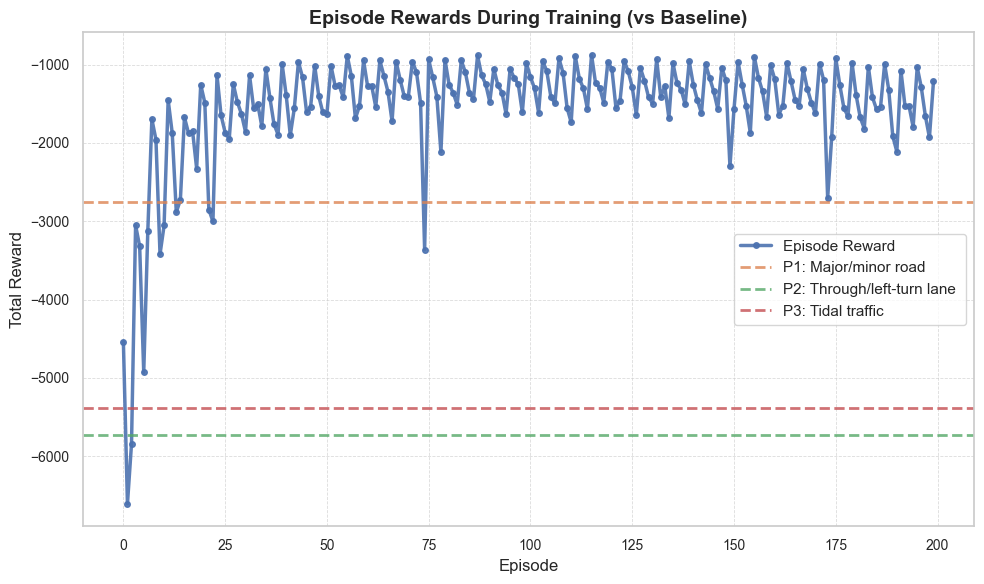

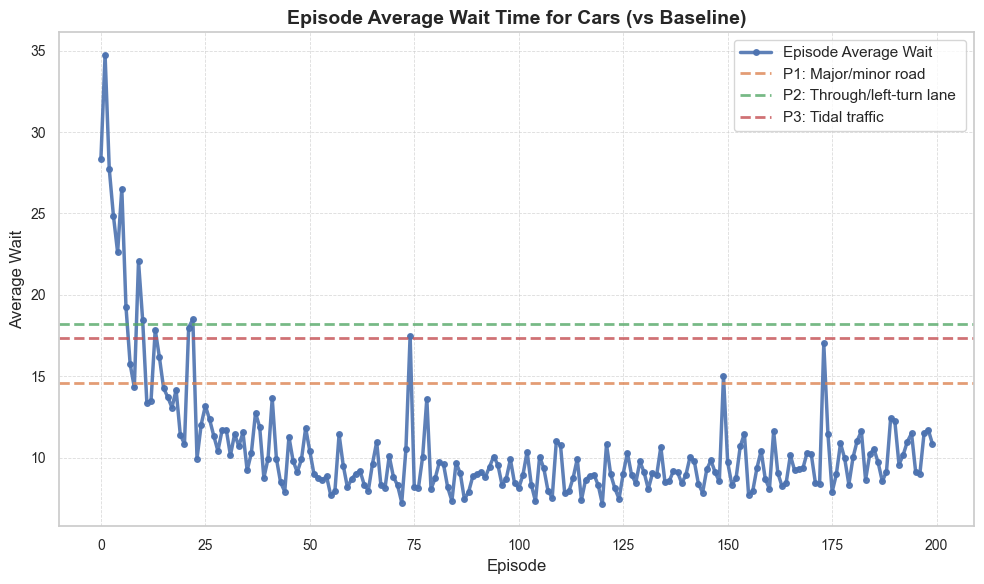

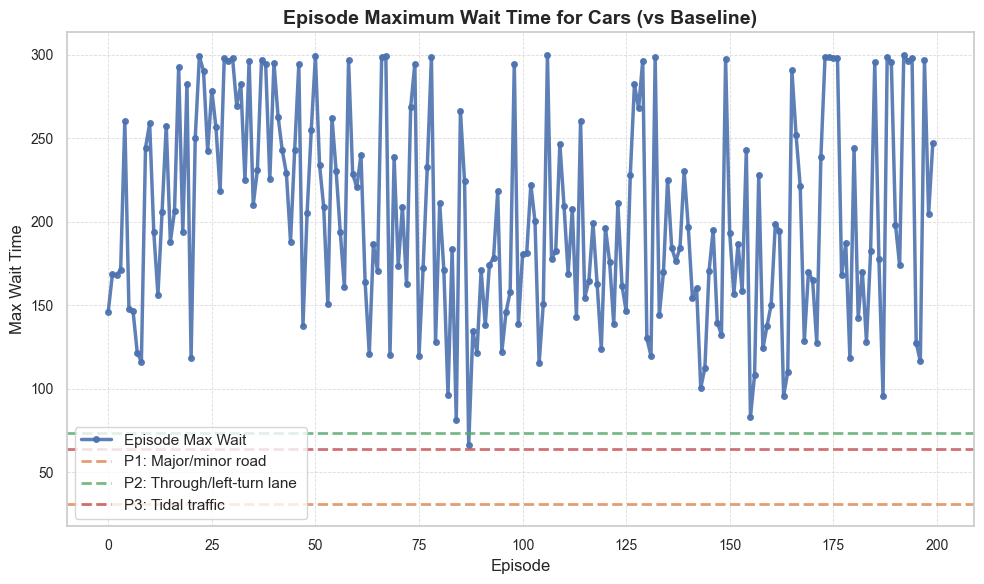

In [130]:
plot_line(cnn_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2758, -5730, -5383])
plot_line(cnn_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [14.57, 18.23, 17.33])
plot_line(cnn_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [31.25, 73.55, 64.05])


In [12]:
policy_cnn = cnn_results["trained_model"]
model_path = f"policy_cnn_nn.pt"
torch.save(policy_cnn.state_dict(), model_path)


NameError: name 'cnn_results' is not defined

In [ ]:
import matplotlib.pyplot as plt

def show_occupancy_grid(grid):
    flipped_grid = torch.flip(grid, dims=[0])  # Flip vertically (along x-axis)
    plt.imshow(flipped_grid.numpy(), cmap='gray')
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    plt.show()


In [14]:
def evaluate_cnn_model_on_pattern(pattern, model_path=f"policy_cnn_nn.pt", episodes=10):
    policy_net = DQN(action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state()

        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            for i in range(4):
                grid = generate_occupancy_grid()  
                show_occupancy_grid(grid, title=f"Time = {i+1}s")
                simulate_time(1)
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
                
            next_state, reward, done, curr_queue = step(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [15]:
for pattern in ["P1", "P2", "P3", "P4"]:
    cnn_results = evaluate_cnn_model_on_pattern(pattern, episodes=10)
    rewards = cnn_results["pattern_rewards"]
    avg_waits = cnn_results["pattern_avg_waits"]
    max_waits = cnn_results["pattern_max_waits"]

    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


TypeError: DQN.__init__() missing 1 required positional argument: 'action_dim'